# TODO:
- Plot loss function over time for all models
- Add something which tracks loss function in own implementation (self.loss = [], append training iteration)
- Add new model comparisons in tensorflow
- confusion matrix for own implementation

# Useful Functions & Dependecies:

In [8]:
#Dependecies
import numpy as np
from scipy.stats import kurtosis

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix


In [1]:
#no linear transform on the data
def compute_statistics_old(samples):
    summary = []
    for sample in samples:
        mu = np.average(sample)
        var = np.var(sample)
        kurt = kurtosis(sample)
        
        quant = np.percentile(sample,[0,25,50,75,100])
        
        #total = np.append(quant,[mu,var,kurt])
        total = np.append(quant,[kurt])
        
        summary.append(total)
        
    return summary

#gathers relevant statistics -> packages into list of feature vectors
def compute_statistics(samples):
    summary = []
    for sample in samples:
        mu = np.average(sample)
        var = np.var(sample)
        kurt = kurtosis(sample)
        
        #testing this line
        sample = (sample-mu)/var
        quant = np.percentile(sample,[0,25,50,75,100])        
        total = np.append(quant,[kurt])
        
        summary.append(total)
        
    return summary

#Maps output argmax to name of distribution (used when testing edge cases)
def dist_map(dist_id):
    dist_mapping = {
        0:"Normal",
        1:"Exponential",
        2:"Poisson",
        3:"Uniform",
        4:"Beta",
        5:"Gamma"
    }
    return dist_mapping[dist_id]

# Sample Generation
- Generating 100 samples for each of the basic continuous distributions learned in an intro to probability course
- They will have random parameters
- Exponential, Normal, Beta, Gamma, Poisson, Uniform


In [2]:
# DIST ID's
# 0 -> normal
# 1 -> exponential
# 2 -> poisson
# 3 -> binomial
# 4 -> uniform
# 5 -> beta
# 6 -> gamma

#Choose number of samples to generate
def gen_samples(num_samples):
    
    #Generate samples for each distribution
    normalSamples = []
    for i in range(num_samples):
        mu = np.random.uniform(-10000,10000)
        sigma = np.random.uniform(1e-9,1000)
        normalSamples.append(np.random.normal(mu,sigma,100))

    expSamples = []
    for i in range(num_samples):
        lambd = np.random.uniform(1e-9,1000)
        expSamples.append(np.random.exponential(lambd,100))

    poissSamples = []
    for i in range(num_samples):
        lambd = np.random.uniform(1e-9,1000)
        poissSamples.append(np.random.poisson(lambd,100))
        
    uniformSamples = []
    for i in range(num_samples):
        a = np.random.uniform(-10000,10000)
        b = np.random.uniform(-10000,10000)
        uniformSamples.append(np.random.uniform(min(a,b),max(a,b),100))
        
    betaSamples = []
    for i in range(num_samples):
        #beta params
        a = np.random.uniform(0,10000)
        b = np.random.uniform(0,10000)
        betaSamples.append(np.random.beta(a,b,100))
        
    gammaSamples = []
    for i in range(num_samples):
        #gamma params
        shape = np.random.uniform(0,10000)
        scale = np.random.uniform(0,10000)
        gammaSamples.append(np.random.gamma(shape,scale,100))
        
    #create matrix of feature vectors, vector of labels
    normal_labels = np.zeros((num_samples,))
    normal_samples = np.vstack(compute_statistics(normalSamples))

    exp_labels = np.ones((num_samples,))
    exp_samples = np.vstack(compute_statistics(expSamples))

    poiss_labels = np.ones((num_samples,)) + 1
    poiss_samples = np.vstack(compute_statistics(poissSamples))
    
    uniform_labels = np.ones((num_samples,)) + 2
    uniform_samples = np.vstack(compute_statistics(uniformSamples))
    
    beta_labels = np.ones((num_samples,)) + 3
    beta_samples = np.vstack(compute_statistics(uniformSamples))
    
    gamma_labels = np.ones((num_samples,)) + 4
    gamma_samples = np.vstack(compute_statistics(gammaSamples))
    
    
    #create the training data
    x = np.vstack([normal_samples,exp_samples,poiss_samples,uniform_samples,beta_samples,gamma_samples])
    y = np.hstack([normal_labels,exp_labels,poiss_labels,uniform_labels,beta_labels,gamma_labels])

    # convert the labels to one-hot encoded vectors
    y = to_categorical(y, num_classes=6)
    
    return x, y

# Testing own implementation of tensorflow

In [3]:
import neural_net as nn

import numpy as np
from scipy.stats import kurtosis
from tensorflow.keras.utils import to_categorical

relu = nn.ReLu()
softmax = nn.Softmax()

In [27]:
model = nn.Neural_Net([nn.FeatureLayer(6, relu),
                 nn.DenseLayer(72, relu),
                 nn.DenseLayer(36, relu),
                 nn.OutputLayer(6, softmax)],
               nn.categorical_crossentropy,
               0.001)

In [29]:
#get training data, test data
num_samples = 100
x_train, y_train = gen_samples(num_samples)
x_test, y_test = gen_samples(num_samples)

#as of now only testing on 3 distributions
x_train = x_train[:num_samples*3]
y_train = y_train[:num_samples*3]
x_test = x_test[:num_samples*3]
y_test = y_test[:num_samples*3]

acc_hist, loss_hist, avg_loss_hist = model.train(x_train,y_train,x_test,y_test,5,25)
#model.check_accuracy(x_test,y_test)[0]

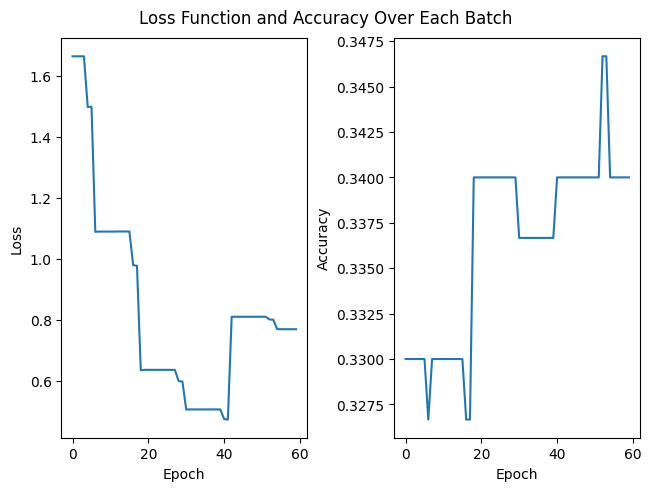

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2,constrained_layout = True)
fig.suptitle('Loss Function and Accuracy Over Each Batch')
ax1.plot(avg_loss_hist)
ax1.set(xlabel='Epoch', ylabel='Loss')

ax2.plot(acc_hist)
ax2.set(xlabel='Epoch', ylabel='Accuracy')

print("")

In [11]:
#np.log()
prob = np.array([10e-100000])
result = np.where(prob > 0, prob, -np.exp(1))
np.log(result, out=result, where=result > 0)

array([-2.71828183])

In [46]:
t = np.random.normal(-400,100,100)
inp = compute_statistics([t])[0]
#inp = np.expand_dims(inp,axis=0) # add batch dimension??

print(y_train[200])

t = np.random.normal(-400,100,100)
inp = compute_statistics([t])[0]
a = dist_map(np.argmax(model.predict(inp)))
b = dist_map(np.argmax(y_train[200]))

print(a,b)
print(a==b)

[0. 0. 1. 0. 0. 0.]
Normal Poisson
False


# Tensorflow Models:

In [123]:
#get training data, test data (keep same for each model)
x_train, y_train = gen_samples(10000)
x_test, y_test = gen_samples(100)

In [139]:
#initialize for confusion matrix
#cite this:
# https://www.kaggle.com/code/mdmashurshalehin/plotting-confusion-matrix-for-tensorflow-model

#convert back to 1d array so confusion matrix works
y_test_labels = np.argmax(y_test, axis=1)

class estimator:
  _estimator_type = ''
  classes_=[]
  def __init__(self, model, classes):
    self.model = model
    self._estimator_type = 'classifier'
    self.classes_ = classes
  def predict(self, X):
    y_prob= self.model.predict(X)
    y_pred = y_prob.argmax(axis=1)
    return y_pred

class_names = ["Normal","Exponential","Poisson","Uniform","Beta","Gamma"]

# Model 1 - ReLu, Adam

In [140]:
# Define model and train -> input shape => how many statistics

#sequential model => one set of inputs, one set of outputs
model1 = Sequential()
model1.add(Dense(72, activation='relu', input_shape=(6,)))
model1.add(Dense(36, activation='relu'))
#softmax last layer -> give probability
model1.add(Dense(6, activation='softmax'))

#use adam since better than SGD
#categorical crossentropy loss
model1.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# train the model (shuffle=True on by default)
history = model1.fit(x_train, y_train, epochs=20, batch_size = 25,
                   validation_data = (x_test,y_test))

# evaluate the model on the training set
print("---------------------------------------------------------------------------------------------")
print("Model evaluation:")
test_loss, test_acc = model.evaluate(x_test, y_test)

Epoch 1/20
2400/2400 [==============================] - 2s 637us/step - loss: 0.7996 - accuracy: 0.6881 - val_loss: 0.5079 - val_accuracy: 0.7200
Epoch 2/20
2400/2400 [==============================] - 1s 566us/step - loss: 0.5005 - accuracy: 0.7714 - val_loss: 0.3863 - val_accuracy: 0.8017
Epoch 3/20
2400/2400 [==============================] - 1s 562us/step - loss: 0.3716 - accuracy: 0.7975 - val_loss: 0.3357 - val_accuracy: 0.8067
Epoch 4/20
2400/2400 [==============================] - 1s 564us/step - loss: 0.3459 - accuracy: 0.8008 - val_loss: 0.3282 - val_accuracy: 0.8000
Epoch 5/20
2400/2400 [==============================] - 1s 561us/step - loss: 0.3414 - accuracy: 0.7995 - val_loss: 0.3221 - val_accuracy: 0.8000
Epoch 6/20
2400/2400 [==============================] - 1s 556us/step - loss: 0.3367 - accuracy: 0.8018 - val_loss: 0.3195 - val_accuracy: 0.8117
Epoch 7/20
2400/2400 [==============================] - 1s 553us/step - loss: 0.3326 - accuracy: 0.8029 - val_loss: 0.3201 -

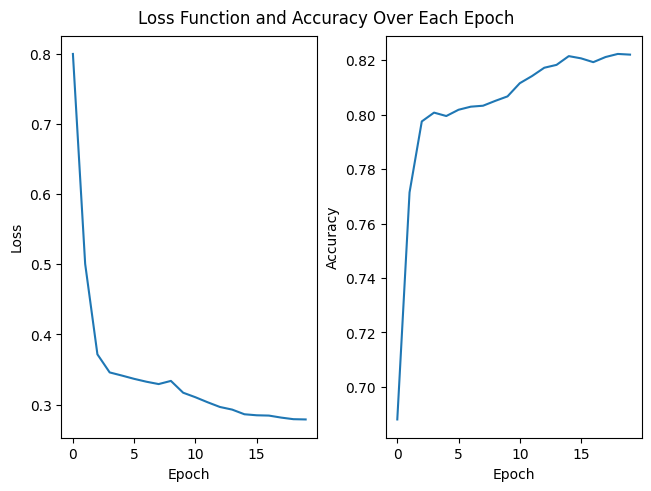

In [141]:
fig, (ax1, ax2) = plt.subplots(1, 2,constrained_layout = True)
fig.suptitle('Loss Function and Accuracy Over Each Epoch')
ax1.plot(history.history['loss'])
ax1.set(xlabel='Epoch', ylabel='Loss')

ax2.plot(history.history['accuracy'])
ax2.set(xlabel='Epoch', ylabel='Accuracy')

print("")

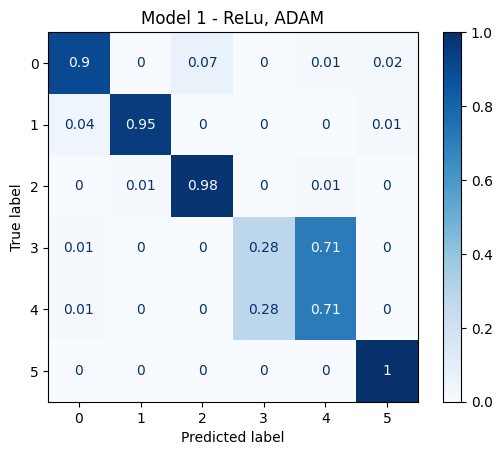

In [181]:
classifier = estimator(model, class_names)

figsize = (12,12)
disp = plot_confusion_matrix(estimator=classifier3, X=x_test, y_true=y_test_labels, 
                      cmap='Blues',normalize='true')
disp.ax_.set_title("Model 1 - ReLu, ADAM")
print("")

# Model 2 - Sigmoid, Adam

In [143]:
# Define model and train -> input shape => how many statistics

#sequential model => one set of inputs, one set of outputs
model2 = Sequential()
model2.add(Dense(72, activation='sigmoid', input_shape=(6,)))
model2.add(Dense(36, activation='sigmoid'))
#softmax last layer -> give probability
model2.add(Dense(6, activation='softmax'))

#use adam since better than SGD
#categorical crossentropy loss
model2.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# train the model (shuffle=True on by default)
history2 = model.fit(x_train, y_train, epochs=20, batch_size = 25,
                   validation_data = (x_test,y_test))

# evaluate the model on the training set
print("---------------------------------------------------------------------------------------------")
print("Model evaluation:")
test_loss2, test_acc2 = model.evaluate(x_test, y_test)

Epoch 1/20
2400/2400 [==============================] - 1s 577us/step - loss: 0.2782 - accuracy: 0.8202 - val_loss: 0.2886 - val_accuracy: 0.8200
Epoch 2/20
2400/2400 [==============================] - 1s 560us/step - loss: 0.2781 - accuracy: 0.8203 - val_loss: 0.2850 - val_accuracy: 0.8217
Epoch 3/20
2400/2400 [==============================] - 1s 548us/step - loss: 0.2767 - accuracy: 0.8235 - val_loss: 0.2883 - val_accuracy: 0.8167
Epoch 4/20
2400/2400 [==============================] - 1s 546us/step - loss: 0.2759 - accuracy: 0.8218 - val_loss: 0.2871 - val_accuracy: 0.8200
Epoch 5/20
2400/2400 [==============================] - 1s 544us/step - loss: 0.2759 - accuracy: 0.8234 - val_loss: 0.2872 - val_accuracy: 0.8200
Epoch 6/20
2400/2400 [==============================] - 1s 555us/step - loss: 0.2749 - accuracy: 0.8227 - val_loss: 0.2863 - val_accuracy: 0.8183
Epoch 7/20
2400/2400 [==============================] - 1s 550us/step - loss: 0.2749 - accuracy: 0.8238 - val_loss: 0.2865 -

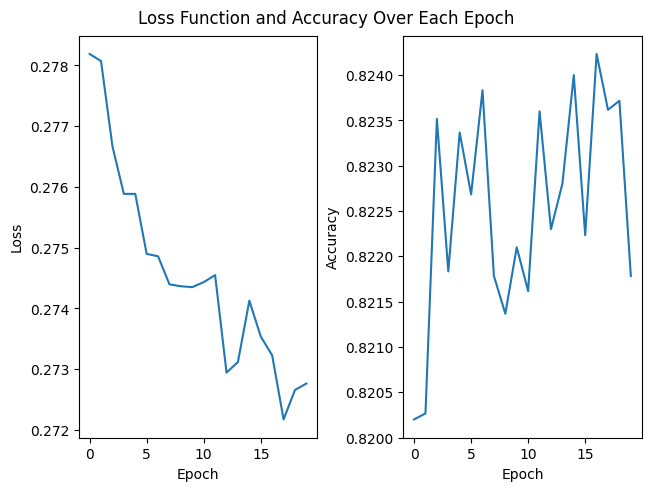

In [144]:
fig, (ax1, ax2) = plt.subplots(1, 2,constrained_layout = True)
fig.suptitle('Loss Function and Accuracy Over Each Epoch')
ax1.plot(history2.history['loss'])
ax1.set(xlabel='Epoch', ylabel='Loss')
ax2.plot(history2.history['accuracy'])
ax2.set(xlabel='Epoch', ylabel='Accuracy')
print("")

In [170]:
t = np.random.normal(-400,100,100)
inp = compute_statistics([t])[0]

#dist_map(np.argmax())
model2.predict(x_test)


array([[0.32661608, 0.15794589, 0.23814926, 0.09098925, 0.06521926,
        0.12108029],
       [0.32749507, 0.1579125 , 0.23746645, 0.09077808, 0.06523474,
        0.12111313],
       [0.32709834, 0.15792528, 0.23777781, 0.09087571, 0.06522582,
        0.12109698],
       ...,
       [0.32558087, 0.15798552, 0.2389528 , 0.09123884, 0.06520085,
        0.12104109],
       [0.3280441 , 0.15789925, 0.23703142, 0.09063902, 0.06525034,
        0.12113594],
       [0.32561108, 0.15798433, 0.23892939, 0.09123152, 0.06520141,
        0.12104226]], dtype=float32)

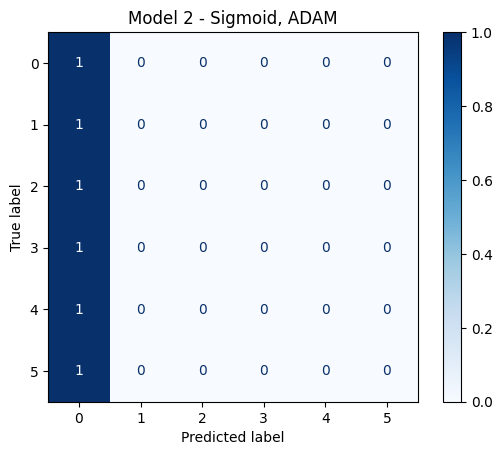

In [180]:
classifier2 = estimator(model2, class_names)

figsize = (12,12)
disp2 = plot_confusion_matrix(estimator=classifier2, X=x_test, y_true=y_test_labels, 
                      cmap='Blues',normalize='true')
disp2.ax_.set_title("Model 2 - Sigmoid, ADAM")
print("")

# Model 3 - ReLu, SGD

In [174]:
# Define model and train -> input shape => how many statistics

#sequential model => one set of inputs, one set of outputs
model3 = Sequential()
model3.add(Dense(72, activation='relu', input_shape=(6,)))
model3.add(Dense(36, activation='relu'))
#softmax last layer -> give probability
model3.add(Dense(6, activation='softmax'))

#use adam since better than SGD
#categorical crossentropy loss
model3.compile(optimizer='sgd', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# train the model (shuffle=True on by default)
history3 = model3.fit(x_train, y_train, epochs=20, batch_size = 25,
                   validation_data = (x_test,y_test))

# evaluate the model on the training set
print("---------------------------------------------------------------------------------------------")
print("Model evaluation:")
test_loss, test_acc = model.evaluate(x_test, y_test)

Epoch 1/20
2400/2400 [==============================] - 1s 529us/step - loss: 1.0861 - accuracy: 0.4792 - val_loss: 0.8714 - val_accuracy: 0.5750
Epoch 2/20
2400/2400 [==============================] - 1s 493us/step - loss: 0.8473 - accuracy: 0.6059 - val_loss: 0.7592 - val_accuracy: 0.6367
Epoch 3/20
2400/2400 [==============================] - 1s 522us/step - loss: 0.7042 - accuracy: 0.6506 - val_loss: 0.6270 - val_accuracy: 0.6600
Epoch 4/20
2400/2400 [==============================] - 1s 498us/step - loss: 0.6194 - accuracy: 0.6715 - val_loss: 0.5801 - val_accuracy: 0.7933
Epoch 5/20
2400/2400 [==============================] - 1s 459us/step - loss: 0.5901 - accuracy: 0.6919 - val_loss: 0.5581 - val_accuracy: 0.7217
Epoch 6/20
2400/2400 [==============================] - 1s 476us/step - loss: 0.5760 - accuracy: 0.7052 - val_loss: 0.5425 - val_accuracy: 0.7383
Epoch 7/20
2400/2400 [==============================] - 1s 467us/step - loss: 0.5658 - accuracy: 0.7134 - val_loss: 0.5321 -

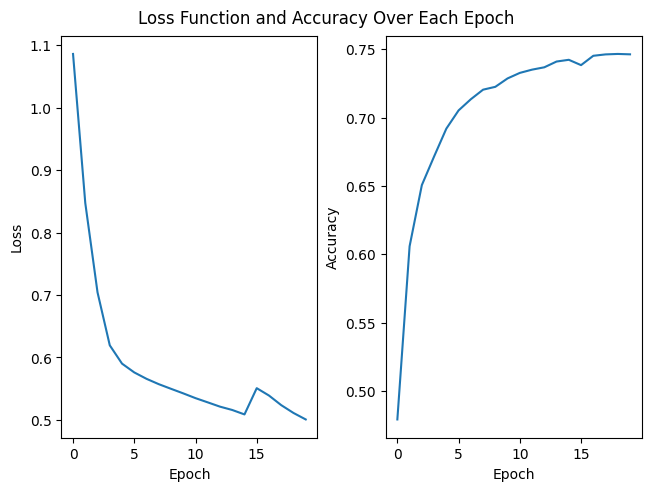

In [175]:
fig, (ax1, ax2) = plt.subplots(1, 2,constrained_layout = True)
fig.suptitle('Loss Function and Accuracy Over Each Epoch')
ax1.plot(history3.history['loss'])
ax1.set(xlabel='Epoch', ylabel='Loss')
ax2.plot(history3.history['accuracy'])
ax2.set(xlabel='Epoch', ylabel='Accuracy')
print("")

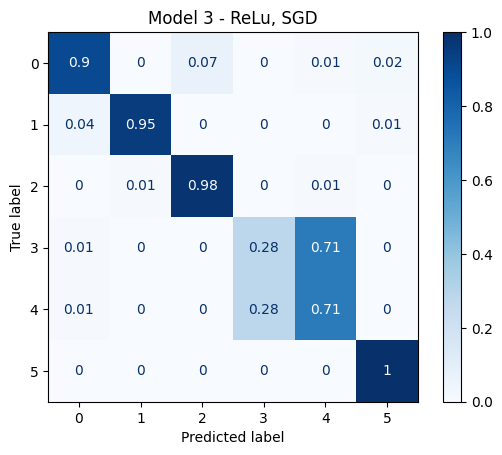

In [179]:
classifier3 = estimator(model3, class_names)

figsize = (12,12)
disp3 = plot_confusion_matrix(estimator=classifier3, X=x_test, y_true=y_test_labels, 
                      cmap='Blues',normalize='true')
disp3.ax_.set_title("Model 3 - ReLu, SGD")
print("")